## Imports

In [ ]:
! pip install matplotlib

In [24]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Torch
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
import torch.optim as optim
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torch.nn as nn

In [3]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## DataLoaders and datasets + preprocessing to standardize image size

In [4]:
# Resize the image and do a center crop, and store them on a tensor
import torchvision.transforms as transforms
img_size = (224, 224)
batch_size=32
train_data_dir = '/home/jovyan/BrainTumour/Training'
test_data_dir = '/home/jovyan/BrainTumour/Testing'

#preprocessing : standardizing the sizes 
#datsets and dataloaders
transform = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_data_dir,transform=transform)


In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [8]:
test_loader.dataset.classes

['glioma', 'meningioma', 'notumor', 'pituitary']

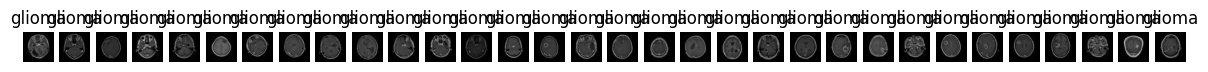

In [9]:
images, labels = next(iter(test_loader))

# Plot the images in a grid
num_images = len(images)
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i in range(num_images):
    image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to NumPy array and permute dimensions
    label =test_dataset.classes[labels[i]]     # Get the label corresponding to the index
    
    axes[i].imshow(image)
    axes[i].set_title(label)
    axes[i].axis('off')

plt.show()

## CNN

## model definition

In [6]:
NUM_OF_CLASSES=4

In [7]:
class CNN(nn.Module):
    def __init__(self,dropout1,dropout2,dropout3,pooling):
        super(CNN, self).__init__()
        # Two convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        # Two fully connected layers
        self.fc1 = nn.Linear(64*112*112, 128)
        self.fc2 = nn.Linear(128, NUM_OF_CLASSES)
        # Batch normalization layers
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm1d(128)
        # Dropout layers
        self.dropout1 = nn.Dropout2d(dropout1)
        self.dropout2 = nn.Dropout2d(dropout2)
        self.dropout3 = nn.Dropout(dropout3)
        # MaxPool layers
        self.maxpool2d = pooling

    def forward(self, x):
        # Pass input through first convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        # Pass output of first conv layer through second convolutional layer
        # Pooling only once on second layer (we could also do it on the first one)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = self.maxpool2d(x, 2)
        # Flatten output of second conv layer
        x = nn.Flatten()(x)
        # Pass flattened output through first fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        # Pass output of first fully connected layer through second fully connected layer
        x = self.fc2(x)
        return x

## Trainer code

In [8]:
def train(model, train_loader, test_loader,training_name,saved_weights_dir, epochs = 10, lr = 0.001):
    # Use Adam optimizer to update model weights
    optimizer = optim.Adam(model.parameters(), lr = lr)
    # Use cross-entropy loss function
    criterion = nn.CrossEntropyLoss()
    # Performance curves data
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over training data
        for batch_number, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero out gradients
            optimizer.zero_grad()
            # Compute model output and loss
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            # Backpropagate loss and update model weights
            loss.backward()
            optimizer.step()
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
        # Calculate epoch loss and accuracy
        epoch_loss /= len(train_loader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')
        
        # Set model to evaluation mode
        model.eval()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over test data
        for inputs, labels in test_loader:
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Compute model output and loss
            # (No grad computation here, as it is the test data)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
        epoch_loss /= len(test_loader)
        epoch_acc = correct/total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')
        savedDir=f'{saved_weights_dir}/{training_name}_epoch_{epoch}.pth'
        torch.save(model.state_dict(), savedDir)
        print(f'saved weights to {savedDir}')
    
    return train_losses, train_accuracies, test_losses, test_accuracies

In [9]:
#accuracy graph
def plot_graph(train_acc, test_acc):
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy vs. Epochs')
    plt.legend()
    plt.show()



In [10]:
def plot_loss_graph(train_loss, test_loss):
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
    plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss vs. Epochs')
    plt.legend()
    plt.show()

## Tester Code

In [13]:
#loads weights, run against all test and train for all epochs to recreate loss and accuracy graph
def load_weights_and_test(model,test_loader,epochs,training_name,saved_weights_dir):
    criterion = nn.CrossEntropyLoss()    
    # recreate test
    test_losses = []
    test_accuracies = []
    
    
    for epoch in range(epochs):
        print(epoch)
        path_model_params=f'{saved_weights_dir}/{training_name}_epoch_{epoch}.pth' #edit this accordingly to folder
        model.load_state_dict(torch.load(path_model_params))
        model.eval()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over test data
        for inputs, labels in test_loader:
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Compute model output and loss
            # (No grad computation here, as it is the test data)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
        epoch_loss /= len(test_loader)
        epoch_acc = correct/total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')    
    return test_losses, test_accuracies

In [11]:
def plot_test_acc(test_acc):
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(' Test Accuracy vs. Epochs')
    plt.legend()
    plt.show()
    

In [12]:
def plot_test_loss(test_loss):
    
    plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(' Test Loss vs. Epochs')
    plt.legend()
    plt.show()

## Running models

# MODEL 1 (Refer to table)
remeber to change the training name and saved_weights_dir accordingly

In [39]:
model = CNN(dropout1=0.25,dropout2=0.5,dropout3=0.25,pooling=F.max_pool2d).to(device)
print(model)
training_name="CNN1"
saved_weights_dir="/home/jovyan/CNN_weights"
max_epochs=15


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=802816, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.25, inplace=False)
)


Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.34375
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.4375
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.5416666666666666
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.578125
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.59375
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.5833333333333334
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.5803571428571429
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.5703125
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.5763888888888888
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.578125
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.5710227272727273
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.5885416666666666
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.5889423076923077
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.5915178571428571
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.5854166666666667
Epoch 1/15, Batch number: 15, Cumulate

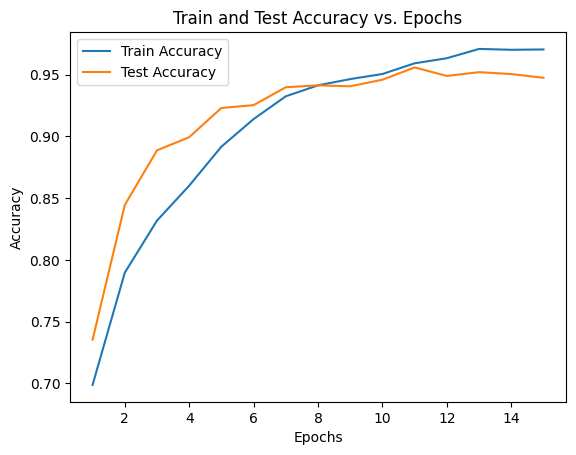

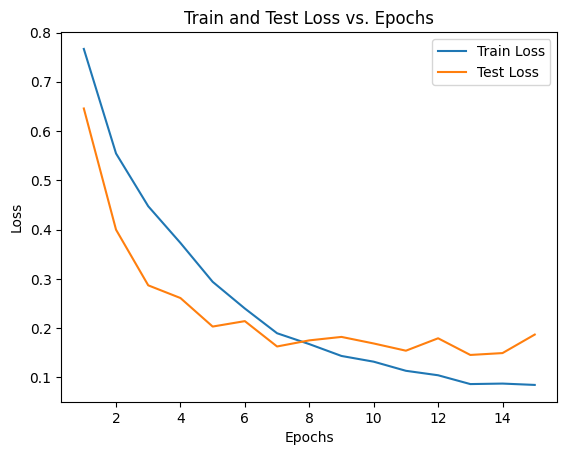

In [26]:
#do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-3)
# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 0.6458, Test accuracy: 0.7353
1
--- Epoch 2/15: Test loss: 0.3997, Test accuracy: 0.8444
2
--- Epoch 3/15: Test loss: 0.2868, Test accuracy: 0.8886
3
--- Epoch 4/15: Test loss: 0.2610, Test accuracy: 0.8993
4
--- Epoch 5/15: Test loss: 0.2031, Test accuracy: 0.9230
5
--- Epoch 6/15: Test loss: 0.2141, Test accuracy: 0.9252
6
--- Epoch 7/15: Test loss: 0.1626, Test accuracy: 0.9397
7
--- Epoch 8/15: Test loss: 0.1750, Test accuracy: 0.9413
8
--- Epoch 9/15: Test loss: 0.1820, Test accuracy: 0.9405
9
--- Epoch 10/15: Test loss: 0.1687, Test accuracy: 0.9458
10
--- Epoch 11/15: Test loss: 0.1540, Test accuracy: 0.9558
11
--- Epoch 12/15: Test loss: 0.1793, Test accuracy: 0.9489
12
--- Epoch 13/15: Test loss: 0.1454, Test accuracy: 0.9519
13
--- Epoch 14/15: Test loss: 0.1492, Test accuracy: 0.9504
14
--- Epoch 15/15: Test loss: 0.1868, Test accuracy: 0.9474


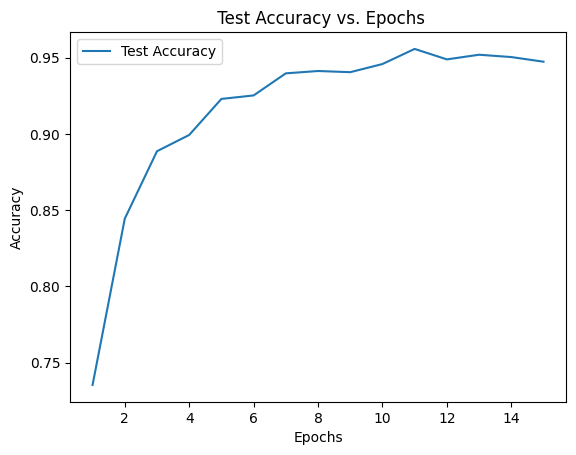

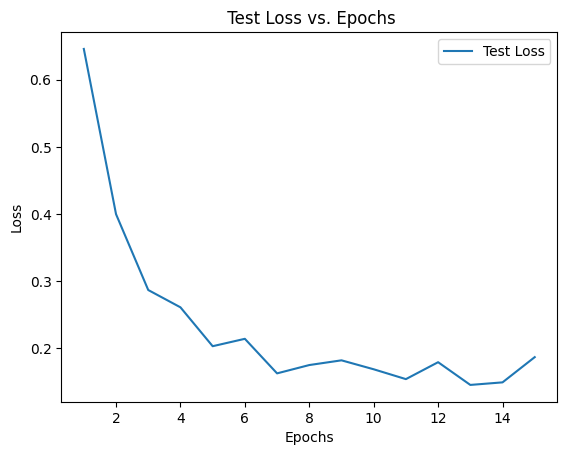

In [40]:
#run this cell to load trained weights
#recreate the test graphs
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_acc(test_accuracies)
plot_test_loss(test_losses)

In [41]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)


max accuracy:  0.9557589626239512
epoch:  11


Model 2

In [42]:
model = CNN(dropout1=0.25,dropout2=0.5,dropout3=0.5,pooling=F.max_pool2d).to(device)
print(model)
training_name="CNN2" #change
saved_weights_dir="/home/jovyan/CNN_weights" #change
max_epochs=15

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=802816, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.5, inplace=False)
)


Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.21875
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.34375
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.3229166666666667
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.34375
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.34375
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.3854166666666667
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.4017857142857143
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.41015625
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.4270833333333333
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.425
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.4346590909090909
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.4427083333333333
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.44471153846153844
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.45089285714285715
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.45625
Epoch 1/15, Batch number: 15, Cumulated accuracy:

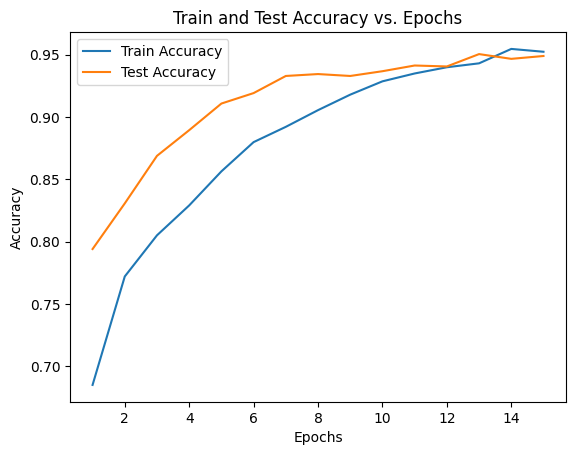

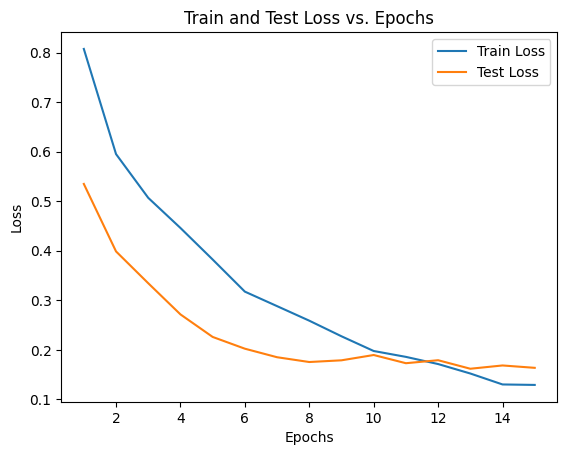

In [17]:
#do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-3)
# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 0.5348, Test accuracy: 0.7941
1
--- Epoch 2/15: Test loss: 0.3986, Test accuracy: 0.8307
2
--- Epoch 3/15: Test loss: 0.3344, Test accuracy: 0.8688
3
--- Epoch 4/15: Test loss: 0.2716, Test accuracy: 0.8894
4
--- Epoch 5/15: Test loss: 0.2261, Test accuracy: 0.9108
5
--- Epoch 6/15: Test loss: 0.2023, Test accuracy: 0.9191
6
--- Epoch 7/15: Test loss: 0.1851, Test accuracy: 0.9329
7
--- Epoch 8/15: Test loss: 0.1755, Test accuracy: 0.9344
8
--- Epoch 9/15: Test loss: 0.1789, Test accuracy: 0.9329
9
--- Epoch 10/15: Test loss: 0.1896, Test accuracy: 0.9367
10
--- Epoch 11/15: Test loss: 0.1730, Test accuracy: 0.9413
11
--- Epoch 12/15: Test loss: 0.1791, Test accuracy: 0.9405
12
--- Epoch 13/15: Test loss: 0.1619, Test accuracy: 0.9504
13
--- Epoch 14/15: Test loss: 0.1685, Test accuracy: 0.9466
14
--- Epoch 15/15: Test loss: 0.1637, Test accuracy: 0.9489


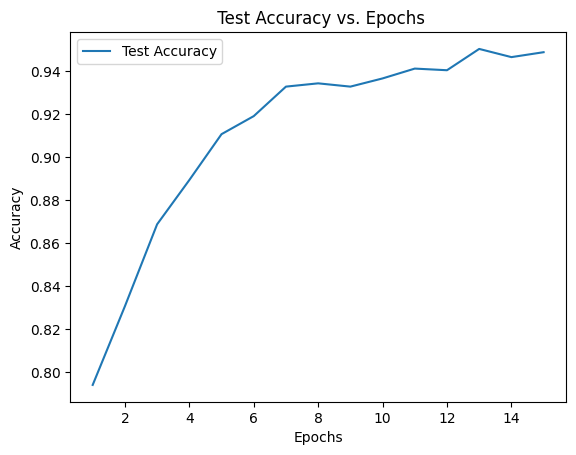

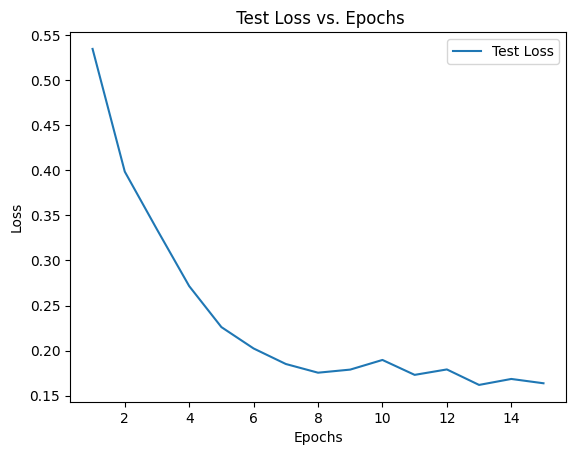

In [43]:
#run this cell to load trained weights
#recreate the test graphs
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_acc(test_accuracies)
plot_test_loss(test_losses)

In [44]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)

max accuracy:  0.950419527078566
epoch:  13


Model 3

In [45]:
model = CNN(dropout1=0.25,dropout2=0.25,dropout3=0.25,pooling=F.max_pool2d).to(device)
print(model)
training_name="CNN3" #change
saved_weights_dir="/home/jovyan/CNN_weights" #change
max_epochs=15

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=802816, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (dropout3): Dropout(p=0.25, inplace=False)
)


Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.125
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.265625
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.3125
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.34375
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.375
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.4010416666666667
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.42410714285714285
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.453125
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.46875
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.4875
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.5056818181818182
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.5130208333333334
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.5264423076923077
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.5290178571428571
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.5291666666666667
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.537109375
Epoc

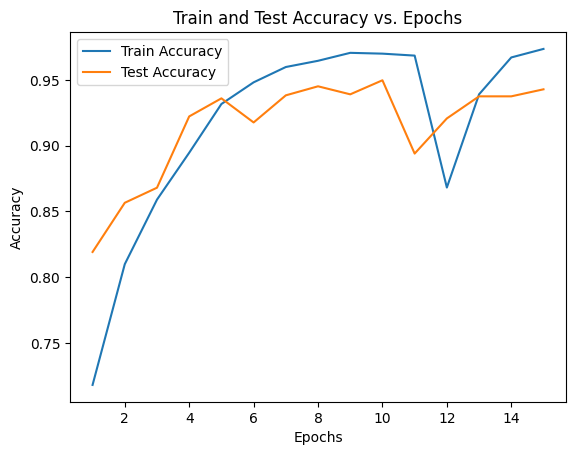

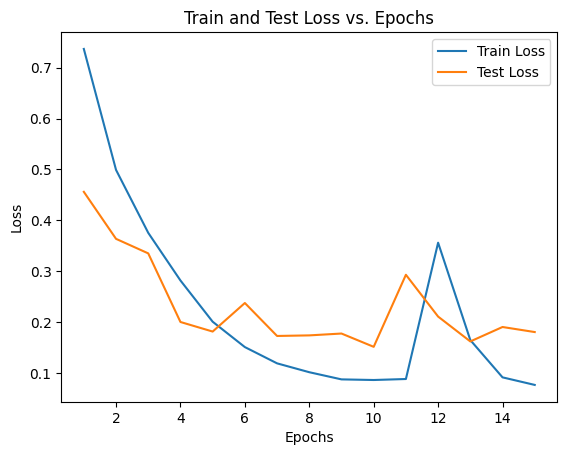

In [19]:
#do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-3)
# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 0.4560, Test accuracy: 0.8192
1
--- Epoch 2/15: Test loss: 0.3635, Test accuracy: 0.8566
2
--- Epoch 3/15: Test loss: 0.3349, Test accuracy: 0.8680
3
--- Epoch 4/15: Test loss: 0.1999, Test accuracy: 0.9222
4
--- Epoch 5/15: Test loss: 0.1811, Test accuracy: 0.9359
5
--- Epoch 6/15: Test loss: 0.2373, Test accuracy: 0.9176
6
--- Epoch 7/15: Test loss: 0.1724, Test accuracy: 0.9382
7
--- Epoch 8/15: Test loss: 0.1736, Test accuracy: 0.9451
8
--- Epoch 9/15: Test loss: 0.1772, Test accuracy: 0.9390
9
--- Epoch 10/15: Test loss: 0.1511, Test accuracy: 0.9497
10
--- Epoch 11/15: Test loss: 0.2928, Test accuracy: 0.8940
11
--- Epoch 12/15: Test loss: 0.2106, Test accuracy: 0.9207
12
--- Epoch 13/15: Test loss: 0.1617, Test accuracy: 0.9375
13
--- Epoch 14/15: Test loss: 0.1901, Test accuracy: 0.9375
14
--- Epoch 15/15: Test loss: 0.1801, Test accuracy: 0.9428


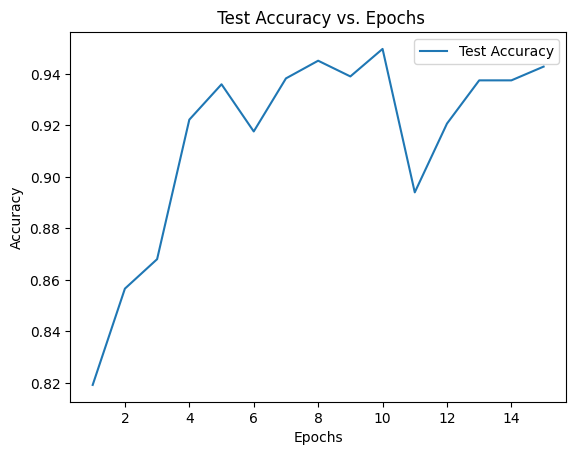

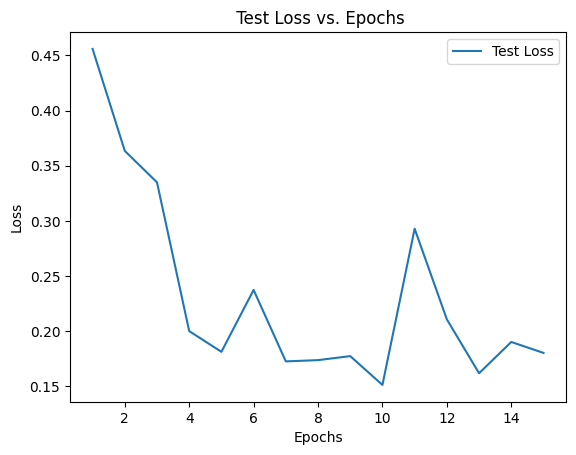

In [46]:
#run this cell to load trained weights
#recreate the test graphs
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_acc(test_accuracies)
plot_test_loss(test_losses)

In [47]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)

max accuracy:  0.9496567505720824
epoch:  10


Model 4

In [48]:
model = CNN(dropout1=0.5,dropout2=0.5,dropout3=0.5,pooling=F.max_pool2d).to(device)
print(model)
training_name="CNN4" #change
saved_weights_dir="/home/jovyan/CNN_weights" #change
max_epochs=15

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=802816, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.5, inplace=False)
)


Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.1875
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.296875
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.3645833333333333
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.3359375
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.35625
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.3489583333333333
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.36607142857142855
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.3828125
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.4027777777777778
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.403125
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.42329545454545453
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.4244791666666667
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.43509615384615385
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.4263392857142857
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.4395833333333333
Epoch 1/15, Batch number: 15, Cum

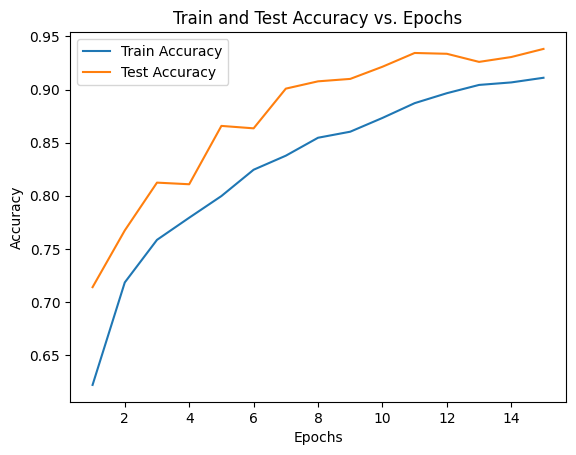

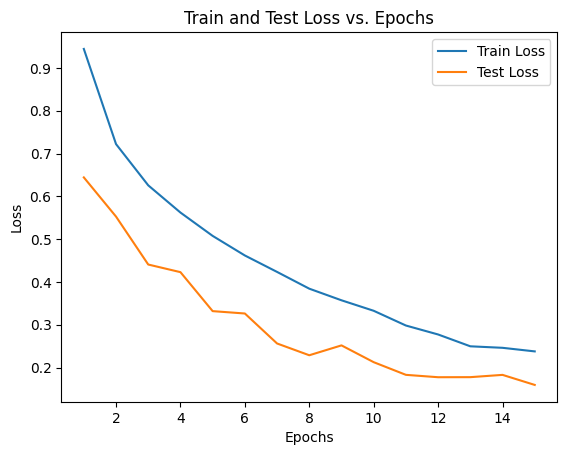

In [28]:
#do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-3)
# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 0.6443, Test accuracy: 0.7140
1
--- Epoch 2/15: Test loss: 0.5527, Test accuracy: 0.7674
2
--- Epoch 3/15: Test loss: 0.4407, Test accuracy: 0.8124
3
--- Epoch 4/15: Test loss: 0.4229, Test accuracy: 0.8108
4
--- Epoch 5/15: Test loss: 0.3318, Test accuracy: 0.8658
5
--- Epoch 6/15: Test loss: 0.3263, Test accuracy: 0.8635
6
--- Epoch 7/15: Test loss: 0.2563, Test accuracy: 0.9008
7
--- Epoch 8/15: Test loss: 0.2288, Test accuracy: 0.9077
8
--- Epoch 9/15: Test loss: 0.2518, Test accuracy: 0.9100
9
--- Epoch 10/15: Test loss: 0.2126, Test accuracy: 0.9214
10
--- Epoch 11/15: Test loss: 0.1830, Test accuracy: 0.9344
11
--- Epoch 12/15: Test loss: 0.1774, Test accuracy: 0.9336
12
--- Epoch 13/15: Test loss: 0.1776, Test accuracy: 0.9260
13
--- Epoch 14/15: Test loss: 0.1829, Test accuracy: 0.9306
14
--- Epoch 15/15: Test loss: 0.1595, Test accuracy: 0.9382


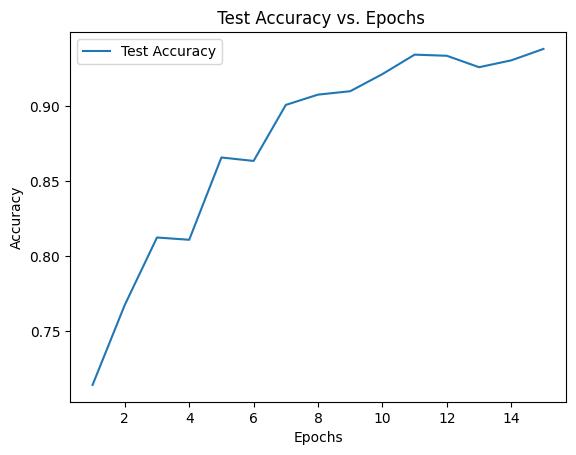

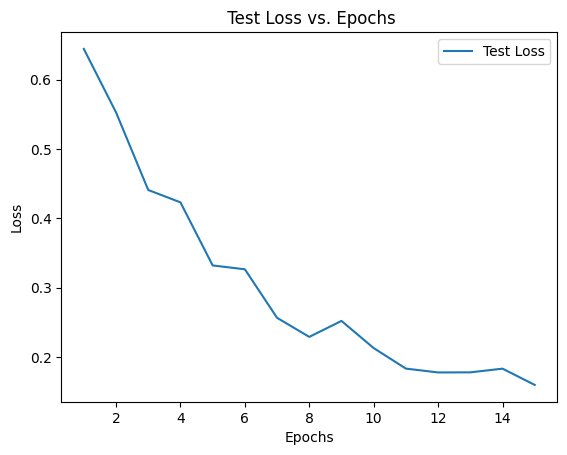

In [49]:
#run this cell to load trained weights
#recreate the test graphs
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_acc(test_accuracies)
plot_test_loss(test_losses)

In [50]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)

max accuracy:  0.9382151029748284
epoch:  15


Model 5

In [51]:
model = CNN(dropout1=0.25,dropout2=0.5,dropout3=0.25,pooling=F.avg_pool2d).to(device)
print(model)
training_name="CNN5" #change
saved_weights_dir="/home/jovyan/CNN_weights" #change
max_epochs=15

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=802816, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.25, inplace=False)
)


Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.25
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.375
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.4166666666666667
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.453125
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.475
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.4895833333333333
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.47767857142857145
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.484375
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.4930555555555556
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.503125
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.5113636363636364
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.5104166666666666
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.5192307692307693
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.5245535714285714
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.525
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.52148

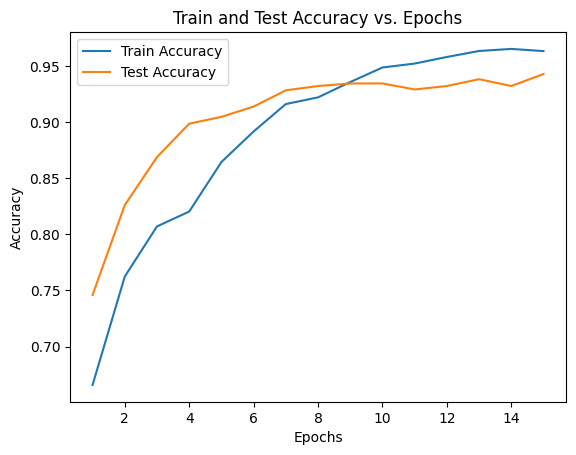

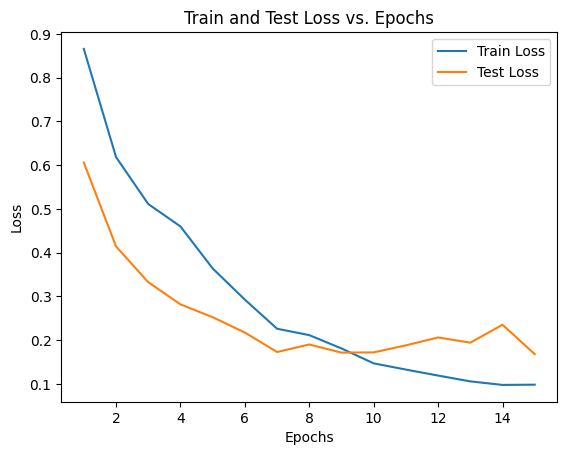

In [30]:
#do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-3)
# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 0.6060, Test accuracy: 0.7460
1
--- Epoch 2/15: Test loss: 0.4144, Test accuracy: 0.8261
2
--- Epoch 3/15: Test loss: 0.3326, Test accuracy: 0.8688
3
--- Epoch 4/15: Test loss: 0.2818, Test accuracy: 0.8986
4
--- Epoch 5/15: Test loss: 0.2525, Test accuracy: 0.9047
5
--- Epoch 6/15: Test loss: 0.2173, Test accuracy: 0.9138
6
--- Epoch 7/15: Test loss: 0.1728, Test accuracy: 0.9283
7
--- Epoch 8/15: Test loss: 0.1901, Test accuracy: 0.9321
8
--- Epoch 9/15: Test loss: 0.1714, Test accuracy: 0.9344
9
--- Epoch 10/15: Test loss: 0.1720, Test accuracy: 0.9344
10
--- Epoch 11/15: Test loss: 0.1881, Test accuracy: 0.9291
11
--- Epoch 12/15: Test loss: 0.2061, Test accuracy: 0.9321
12
--- Epoch 13/15: Test loss: 0.1942, Test accuracy: 0.9382
13
--- Epoch 14/15: Test loss: 0.2352, Test accuracy: 0.9321
14
--- Epoch 15/15: Test loss: 0.1680, Test accuracy: 0.9428


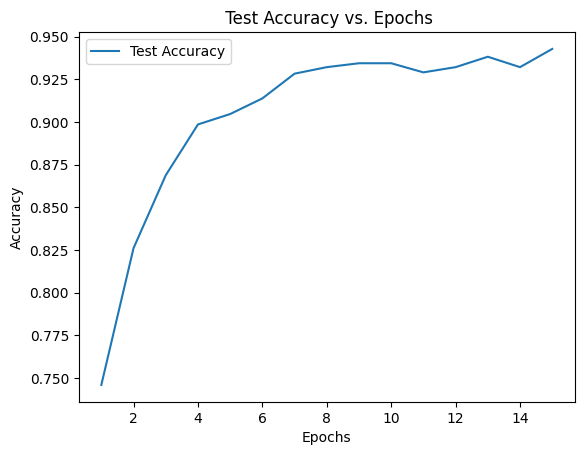

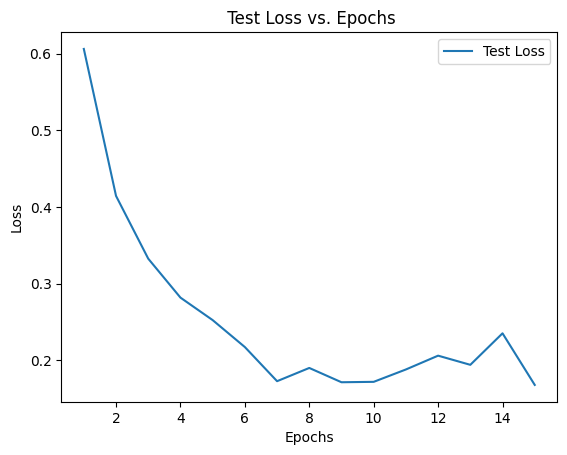

In [52]:
#run this cell to load trained weights
#recreate the test graphs
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_acc(test_accuracies)
plot_test_loss(test_losses)

In [53]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)

max accuracy:  0.9427917620137299
epoch:  15


Model 6

In [54]:
model = CNN(dropout1=0.25,dropout2=0.5,dropout3=0.5,pooling=F.avg_pool2d).to(device)
print(model)
training_name="CNN6" #change
saved_weights_dir="/home/jovyan/CNN_weights" #change
max_epochs=15

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=802816, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.5, inplace=False)
)


Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.21875
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.359375
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.40625
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.421875
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.45
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.4427083333333333
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.46875
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.47265625
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.4756944444444444
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.490625
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.48863636363636365
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.4869791666666667
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.47115384615384615
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.4575892857142857
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.4666666666666667
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.466796

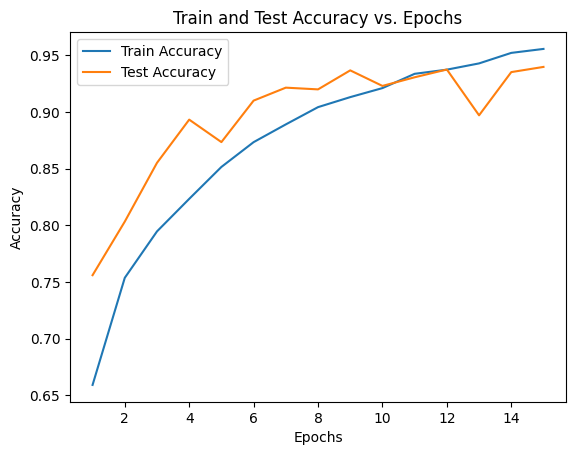

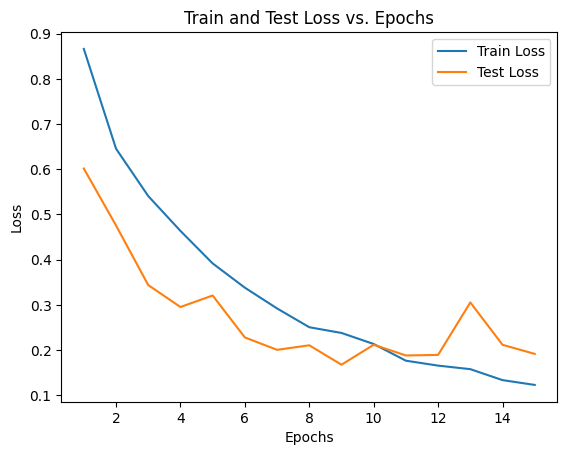

In [32]:
#do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-3)
# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 0.6016, Test accuracy: 0.7559
1
--- Epoch 2/15: Test loss: 0.4756, Test accuracy: 0.8032
2
--- Epoch 3/15: Test loss: 0.3438, Test accuracy: 0.8551
3
--- Epoch 4/15: Test loss: 0.2952, Test accuracy: 0.8932
4
--- Epoch 5/15: Test loss: 0.3207, Test accuracy: 0.8734
5
--- Epoch 6/15: Test loss: 0.2279, Test accuracy: 0.9100
6
--- Epoch 7/15: Test loss: 0.2005, Test accuracy: 0.9214
7
--- Epoch 8/15: Test loss: 0.2105, Test accuracy: 0.9199
8
--- Epoch 9/15: Test loss: 0.1676, Test accuracy: 0.9367
9
--- Epoch 10/15: Test loss: 0.2117, Test accuracy: 0.9230
10
--- Epoch 11/15: Test loss: 0.1880, Test accuracy: 0.9306
11
--- Epoch 12/15: Test loss: 0.1893, Test accuracy: 0.9375
12
--- Epoch 13/15: Test loss: 0.3053, Test accuracy: 0.8970
13
--- Epoch 14/15: Test loss: 0.2116, Test accuracy: 0.9352
14
--- Epoch 15/15: Test loss: 0.1915, Test accuracy: 0.9397


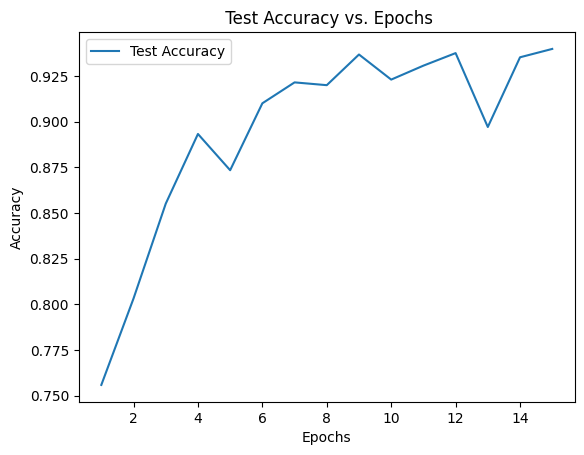

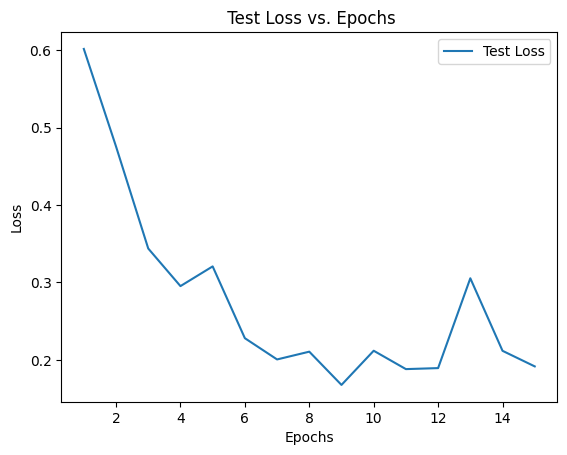

In [55]:
#run this cell to load trained weights
#recreate the test graphs
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_acc(test_accuracies)
plot_test_loss(test_losses)

In [56]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)

max accuracy:  0.9397406559877955
epoch:  15


Model 7

In [57]:
model = CNN(dropout1=0.25,dropout2=0.25,dropout3=0.25,pooling=F.avg_pool2d).to(device)
print(model)
training_name="CNN7" #change
saved_weights_dir="/home/jovyan/CNN_weights" #change
max_epochs=15

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=802816, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (dropout3): Dropout(p=0.25, inplace=False)
)


Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.1875
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.265625
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.3541666666666667
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.375
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.40625
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.4375
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.4642857142857143
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.47265625
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.4826388888888889
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.496875
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.5
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.5026041666666666
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.5024038461538461
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.5066964285714286
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.5125
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.51171875
Epoch 1/15, Batch

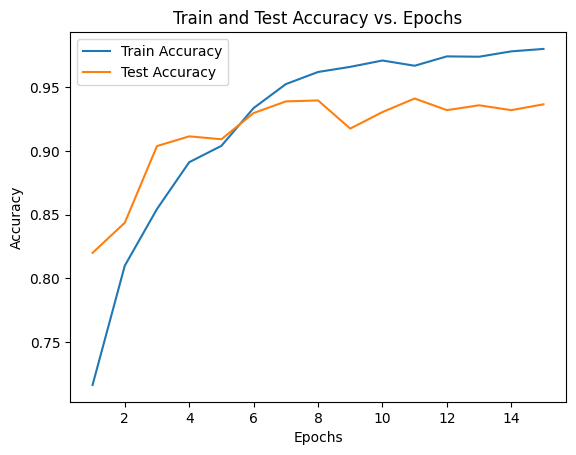

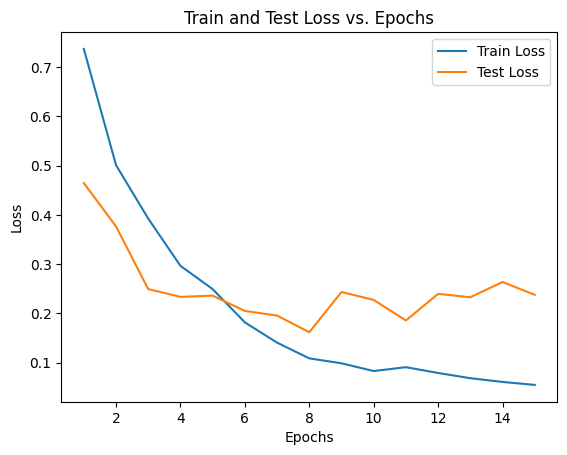

In [34]:
#do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-3)
# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 0.4646, Test accuracy: 0.8200
1
--- Epoch 2/15: Test loss: 0.3766, Test accuracy: 0.8436
2
--- Epoch 3/15: Test loss: 0.2493, Test accuracy: 0.9039
3
--- Epoch 4/15: Test loss: 0.2335, Test accuracy: 0.9115
4
--- Epoch 5/15: Test loss: 0.2360, Test accuracy: 0.9092
5
--- Epoch 6/15: Test loss: 0.2050, Test accuracy: 0.9298
6
--- Epoch 7/15: Test loss: 0.1955, Test accuracy: 0.9390
7
--- Epoch 8/15: Test loss: 0.1617, Test accuracy: 0.9397
8
--- Epoch 9/15: Test loss: 0.2434, Test accuracy: 0.9176
9
--- Epoch 10/15: Test loss: 0.2273, Test accuracy: 0.9306
10
--- Epoch 11/15: Test loss: 0.1856, Test accuracy: 0.9413
11
--- Epoch 12/15: Test loss: 0.2396, Test accuracy: 0.9321
12
--- Epoch 13/15: Test loss: 0.2327, Test accuracy: 0.9359
13
--- Epoch 14/15: Test loss: 0.2637, Test accuracy: 0.9321
14
--- Epoch 15/15: Test loss: 0.2377, Test accuracy: 0.9367


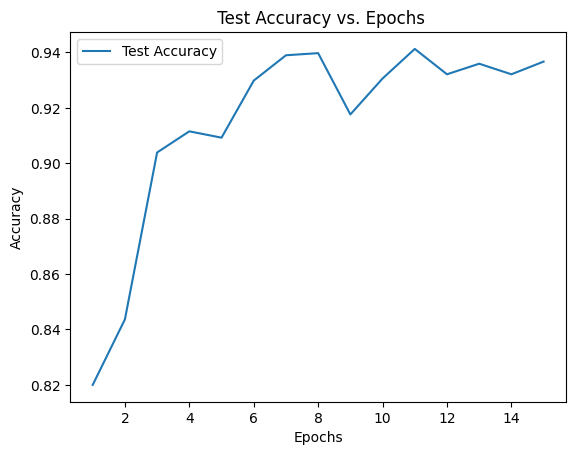

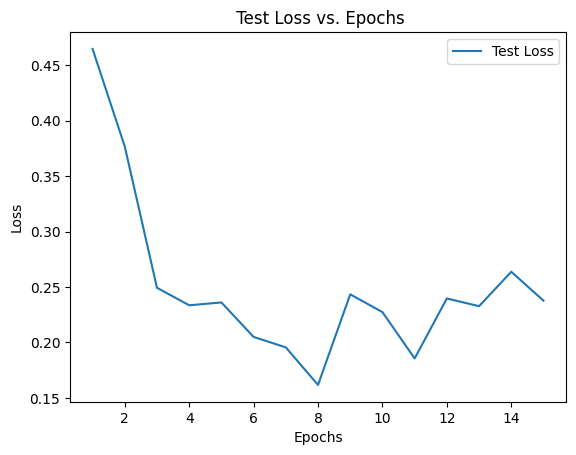

In [58]:
#run this cell to load trained weights
#recreate the test graphs
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_acc(test_accuracies)
plot_test_loss(test_losses)

In [59]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)

max accuracy:  0.9412662090007627
epoch:  11


Model 8

In [35]:
model = CNN(dropout1=0.5,dropout2=0.5,dropout3=0.5,pooling=F.avg_pool2d).to(device)
print(model)
training_name="CNN8" #change
saved_weights_dir="/home/jovyan/CNN_weights" #change
max_epochs=15

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=802816, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.5, inplace=False)
)


Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.125
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.21875
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.3125
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.3359375
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.35625
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.375
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.4017857142857143
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.4140625
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.40625
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.4
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.4289772727272727
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.4348958333333333
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.43990384615384615
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.44419642857142855
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.45
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.44921875
Epoch 1/15, Batch number: 16, 

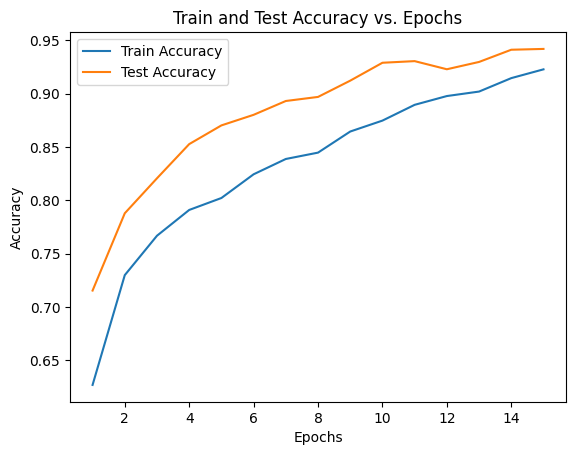

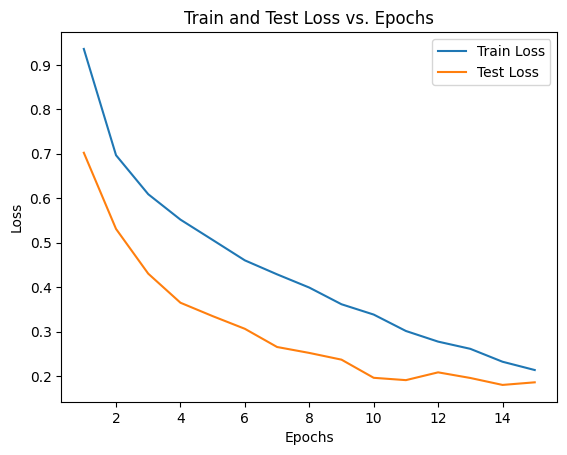

In [36]:
#do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-3)
# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 0.7023, Test accuracy: 0.7155
1
--- Epoch 2/15: Test loss: 0.5310, Test accuracy: 0.7879
2
--- Epoch 3/15: Test loss: 0.4304, Test accuracy: 0.8207
3
--- Epoch 4/15: Test loss: 0.3650, Test accuracy: 0.8528
4
--- Epoch 5/15: Test loss: 0.3348, Test accuracy: 0.8703
5
--- Epoch 6/15: Test loss: 0.3063, Test accuracy: 0.8802
6
--- Epoch 7/15: Test loss: 0.2654, Test accuracy: 0.8932
7
--- Epoch 8/15: Test loss: 0.2521, Test accuracy: 0.8970
8
--- Epoch 9/15: Test loss: 0.2369, Test accuracy: 0.9123
9
--- Epoch 10/15: Test loss: 0.1961, Test accuracy: 0.9291
10
--- Epoch 11/15: Test loss: 0.1908, Test accuracy: 0.9306
11
--- Epoch 12/15: Test loss: 0.2084, Test accuracy: 0.9230
12
--- Epoch 13/15: Test loss: 0.1957, Test accuracy: 0.9298
13
--- Epoch 14/15: Test loss: 0.1801, Test accuracy: 0.9413
14
--- Epoch 15/15: Test loss: 0.1859, Test accuracy: 0.9420


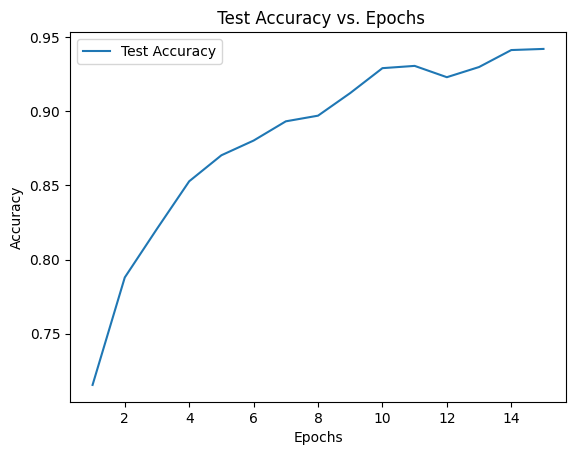

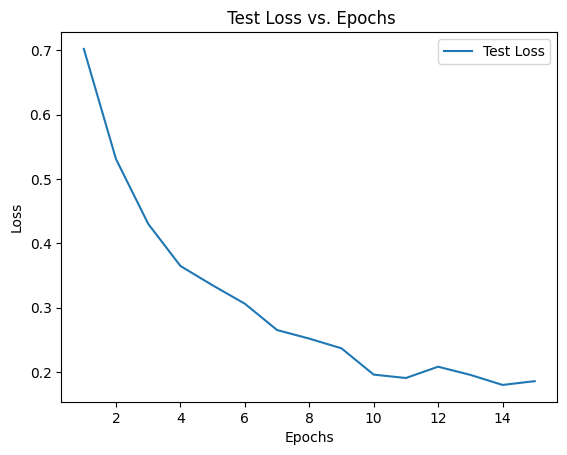

In [37]:
#run this cell to load trained weights
#recreate the test graphs
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_acc(test_accuracies)
plot_test_loss(test_losses)

In [38]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)

max accuracy:  0.9420289855072463
epoch:  15
